Before SMOTE: {1: 28923, 0: 242}
After SMOTE: {1: 28923, 0: 28923}

=== Default Threshold (0.5) ===
              precision    recall  f1-score   support

           0       0.37      0.32      0.34        60
           1       0.99      1.00      0.99      7232

    accuracy                           0.99      7292
   macro avg       0.68      0.66      0.67      7292
weighted avg       0.99      0.99      0.99      7292

ROC-AUC Score: 0.8501924317846608
Confusion Matrix:
 [[  19   41]
 [  33 7199]]

=== Tuned Threshold (0.3) ===
              precision    recall  f1-score   support

           0       0.33      0.22      0.26        60
           1       0.99      1.00      0.99      7232

    accuracy                           0.99      7292
   macro avg       0.66      0.61      0.63      7292
weighted avg       0.99      0.99      0.99      7292

Confusion Matrix:
 [[  13   47]
 [  26 7206]]


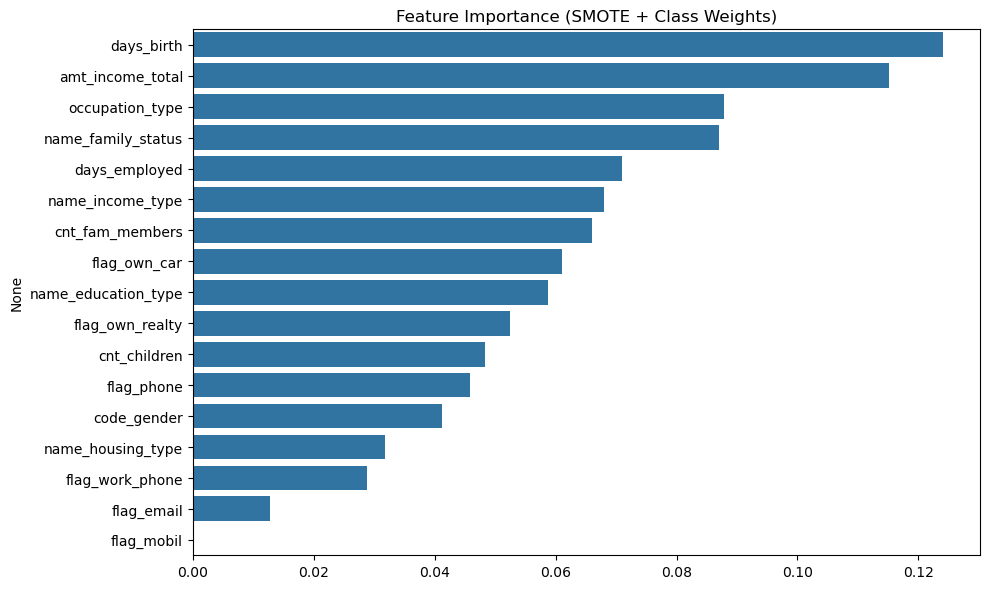

In [6]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# === Step 0: Fix joblib/loky warning ===
os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count())

# === Step 1: Load datasets ===
app = pd.read_csv("application_record.csv")
credit = pd.read_csv("credit_record.csv")

# === Step 2: Clean column names ===
app.columns = app.columns.str.strip().str.lower()
credit.columns = credit.columns.str.strip().str.lower()

# === Step 3: Create target column from credit history ===
def label_status(status_series):
    if any(s in ['3','4','5'] for s in status_series):
        return 0  # bad/rejected
    else:
        return 1  # good/approved

target = credit.groupby("id")["status"].apply(label_status).reset_index()
target.rename(columns={"status": "application_status"}, inplace=True)

# === Step 4: Merge with application data ===
df = app.merge(target, on="id")

# === Step 5: Drop ID/date columns if present ===
drop_cols = ['id', 'application_creation_date']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# === Step 6: Encode categorical features ===
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# === Step 7: Separate features and target ===
X = df.drop(columns="application_status")
y = df["application_status"]

# === Step 8: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# === Step 9: Feature scaling ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Step 10: Apply SMOTE oversampling ===
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

# === Step 11: Train Random Forest with class weights ===
model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
model.fit(X_train_res, y_train_res)

# === Step 12: Predictions and evaluation ===
y_proba = model.predict_proba(X_test)[:, 1]

# Default threshold (0.5)
y_pred_default = (y_proba > 0.5).astype(int)
print("\n=== Default Threshold (0.5) ===")
print(classification_report(y_test, y_pred_default))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_default))

# Tuned threshold (0.3) to boost recall for bad clients
y_pred_tuned = (y_proba > 0.3).astype(int)
print("\n=== Tuned Threshold (0.3) ===")
print(classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

# === Step 13: Feature importance plot ===
importances = model.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance (SMOTE + Class Weights)")
plt.tight_layout()
plt.show()
